In [1]:
%load_ext autoreload
%autoreload 2

# Multilayer perceptron with PyTorch

Set a seed for reproducibility:

In [2]:
SEED = 42

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

torch.manual_seed(SEED)
np.random.seed(SEED)

## Case study: Image classification

In this case study, we will use the MNIST dataset to classify handwritten digits. The dataset contains 70,000 images of handwritten digits from 0 to 9. Each image has 28x28 pixels, and each pixel is represented by a value between 0 and 255.

In [4]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = False
FOLDERNAME = None  # only used if TEST_ON_COLAB is True
# FOLDERNAME = "Colab Notebooks/cnn/2_colab-with-drive"

assert not (FOLDERNAME is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"

### Dataset

In [5]:
DATASET_OPENML_ID = "mnist_784" # try to use a dataset that is already in the OpenML-CC18 benchmark

assert DATASET_OPENML_ID is not None, "DATASET_OPENML_ID is not set"

Downloading the dataset:

In [6]:
# Create dataset directory
import os

if TEST_ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive

    drive.mount("/content/drive")
    cache_dir = f"/content/drive/My Drive/{FOLDERNAME}/dataset/{DATASET_OPENML_ID}"
else:
    cache_dir = f"dataset/{DATASET_OPENML_ID}"

os.makedirs(cache_dir, exist_ok=True)

# Fetching the dataset
from sklearn.datasets import fetch_openml

X_file_path = f"{cache_dir}/X.npy"
y_file_path = f"{cache_dir}/y.npy"

# Check if the dataset files already exist
if not (os.path.exists(X_file_path) and os.path.exists(y_file_path)):
    # Fetch the dataset where X is the data and y is the target
    X, y = fetch_openml(DATASET_OPENML_ID, as_frame=False, cache=True, return_X_y=True)

    # Save the dataset as numpy arrays
    np.save(X_file_path, X.astype(np.float32))
    np.save(y_file_path, y)
    print(f"{DATASET_OPENML_ID} dataset downloaded and saved successfully to {cache_dir}.")
else:
    X = np.load(X_file_path, allow_pickle=True)
    y = np.load(y_file_path, allow_pickle=True)
    print(f"{DATASET_OPENML_ID} dataset already exists in {cache_dir}. Skipping download.")

print(X.shape)
print(X.min(), X.max())

mnist_784 dataset already exists in dataset/mnist_784. Skipping download.
(70000, 784)
0.0 255.0


Visualizing a few samples from the dataset:

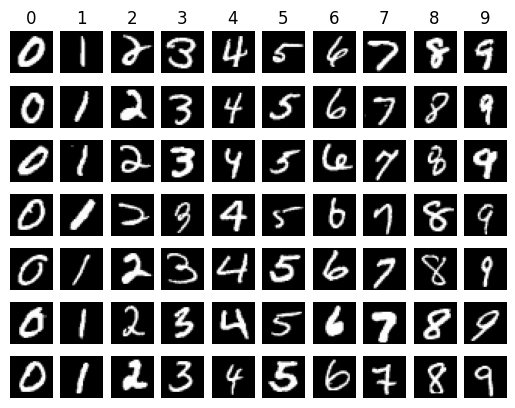

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [i for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for cls in classes:
    idxs = np.flatnonzero(y == str(cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].reshape((28, -1)).astype("uint8"), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

Split the dataset into training and test sets:

In [8]:
from sklearn.model_selection import train_test_split

y = y.astype(int)  # convert string labels to integers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Pytorch model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLPClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden=10, num_outputs=1000):
        """ Constructor for the MLPClassifier class

        Args:
            num_inputs (int): number of input units
            num_hidden (int): number of hidden units
            num_outputs (int): number of output units
        """
        super(MLPClassifier, self).__init__()
        
        # Layers
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.sigmoid = nn.Sigmoid()
        # self.relu = nn.ReLU() # uncomment this line to use ReLU activation
        self.fc2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        """ Forward pass of the MLPClassifier.

        Args:
            x (torch.Tensor): input tensor
        """
        x = self.fc1(x)
        x = self.sigmoid(x)
        # x = self.relu(x) # uncomment this line to use ReLU activation
        x = self.fc2(x)
        return x

model = MLPClassifier(num_inputs=X_train.shape[1], num_hidden=10, num_outputs=10)
model.to(device)

MLPClassifier(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)

### Data preparation

Now, we use the DataLoader class to load the data in batches. More on datasets and dataloaders can be found [here](https://pytorch.org/docs/stable/data.html).

In [10]:
# Set the dataloaders

from torch.utils.data import DataLoader, TensorDataset

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Optimizer and loss function

In [11]:
torch.backends.cudnn.deterministic = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

/home/thiagopx/projects/ann/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Training the model

In [12]:
from tqdm.notebook import tqdm

# Training loop
num_epochs = 100
pbar = tqdm(total=num_epochs, desc="Training: ")
for epoch in range(num_epochs):

    # Update the progress bar after each iteration
    pbar.update(1)

    # Set model to training mode
    model.train()

    # Statistics
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data in batches
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass (logits)
        outputs = model(inputs)

        # Ignore values and get the index of the maximum value (predictions)
        pred_labels = torch.argmax(outputs, dim=1)

        # Calculate the loss (softmax is calculated internally)
        loss = criterion(outputs, labels)

        # Backward pass (backpropagation)
        loss.backward()

        # Optimize (update weights)
        optimizer.step()
        #
        # Update statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(pred_labels == labels.data).item()

    # Update tqdm bar
    num_samples = len(train_dataset)
    epoch_loss = running_loss / num_samples
    epoch_accuracy = running_corrects / num_samples
    pbar.set_description(f"Training: Epoch loss: {epoch_loss:.3f} Acc: {epoch_accuracy:.3f}")

# Close the progress bar when done
pbar.close()

# Save the model
if not os.path.exists("model"):
    os.makedirs("model")
torch.save(model.state_dict(), "model/mnist-torch.pth")

Training:   0%|          | 0/100 [00:00<?, ?it/s]

### Testing the model

In [71]:
import json
from sklearn.metrics import f1_score

# Load the model
model = MLPClassifier(num_inputs=X_train.shape[1], num_hidden=10, num_outputs=10)
params = torch.load("model/mnist-torch.pth", map_location=device)
model.load_state_dict(params)

# Set model to evaluation mode
model.eval()

pred_labels_all = []
true_labels_all = []

# Iterate over data
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    pred_labels = torch.argmax(outputs, dim=1)
    pred_labels_all.append(pred_labels)
    true_labels_all.append(labels)

pred_labels = torch.cat(pred_labels_all, dim=0).cpu().numpy()
true_labels = torch.cat(true_labels_all, dim=0).numpy()

# Generate (and dump) a classification report
report = {
    "metrics": {
        "accuracy": (pred_labels == true_labels).mean(),
        "f1-score_micro": f1_score(true_labels, pred_labels, average="micro"),
        "f1-score_macro": f1_score(true_labels, pred_labels, average="macro"),
    },
    "prediction": pred_labels.tolist(),
    "ground_truth": true_labels.tolist(),
}

# Save report
if not os.path.exists("report"):
    os.makedirs("report")
json.dump(report, open(f"report/report-mnist.json", "w"))

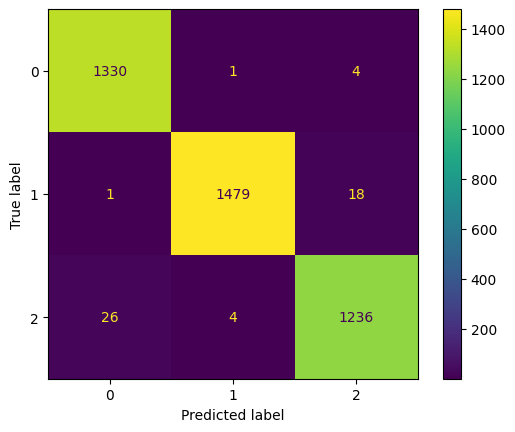


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1374
           1       0.96      0.96      0.96      1545
           2       0.90      0.89      0.89      1391
           3       0.90      0.85      0.87      1463
           4       0.92      0.92      0.92      1328
           5       0.84      0.86      0.85      1256
           6       0.92      0.94      0.93      1353
           7       0.93      0.90      0.91      1500
           8       0.87      0.87      0.87      1374
           9       0.88      0.89      0.88      1416

    accuracy                           0.91     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.91      0.91      0.90     14000



In [72]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, pred_labels)

print("\nClassification Report:")
print(class_report)